# Data acquisition notebook
## CT State EV registration data

In [54]:
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import requests
from bs4 import BeautifulSoup

# Get data from the url 

In [55]:
url = 'https://www.atlasevhub.com/materials/state-ev-registration-data/#data'
reqs = requests.get(url)
soup = BeautifulSoup(reqs.text, 'html.parser')
links=[link.get('href') for link in soup.find_all('a') ]
data=[i for i in links if len(i.split('/'))>1 and i.split('/')[1]=='public']
data=[i for i in data if i.split('.')[-1]=='csv']
state_name=[i.split('/')[3].split('_')[0].upper() for i in data]
print(state_name)

['CA', 'CO', 'CT', 'FL', 'MT', 'MI', 'MN', 'NJ', 'NY', 'OR', 'TN', 'TX', 'VT', 'VA', 'WA', 'WI']


In [56]:
# dt=pd.read_csv('https://www.atlasevhub.com/'+data[0])
# dt.sample(50000).to_csv(r'./CA_data.csv',index=False)  ## original data had 2.5M (2542443) datapoints that was too large for github

In [57]:
# dt.to_csv(r'./CA_data.csv',index=False)
# dt=pd.read_csv(r'./CA_data_small50K.csv',usecols=['Registration Valid Date','Vehicle Name'])
dt=pd.read_csv(r'./CA_data_small50K.csv')
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Registration Valid Date  50000 non-null  object
 1   Vehicle Name             50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [58]:
dt.head()

,Registration Valid Date,Vehicle Name
0,2016-01-01,Tesla Model S
1,2014-01-01,Ford Fusion Energi
2,2017-01-01,Toyota Prius Prime
3,2019-01-01,Tesla Model 3
4,2020-01-01,Chevrolet Volt


# Data cleaning

1. *search for NaN*

In [59]:
dt.isna().sum()

Registration Valid Date    0
Vehicle Name               0
dtype: int64

Registration Expiration Date is not available, let's drop this column. 

In [60]:
dt=dt.dropna(axis=1)

In [61]:
print(dt.shape)

(50000, 2)


In [62]:
dt.head()

,Registration Valid Date,Vehicle Name
0,2016-01-01,Tesla Model S
1,2014-01-01,Ford Fusion Energi
2,2017-01-01,Toyota Prius Prime
3,2019-01-01,Tesla Model 3
4,2020-01-01,Chevrolet Volt


# Remove columns with a unique value
# Add this function in data cleaning class

In [63]:
# Remove columns with a unique value; will also remove columns with only 0 
print(f"removing {sum(dt.nunique()<2)} columns values with a unique value")
print(f"Before: dt.shape={dt.shape}")
dt=dt.loc[:,dt.nunique()>1]
print(f"After: dt.shape={dt.shape} \n")

removing 0 columns values with a unique value
Before: dt.shape=(50000, 2)
After: dt.shape=(50000, 2) 



In [64]:
dt.head()

,Registration Valid Date,Vehicle Name
0,2016-01-01,Tesla Model S
1,2014-01-01,Ford Fusion Energi
2,2017-01-01,Toyota Prius Prime
3,2019-01-01,Tesla Model 3
4,2020-01-01,Chevrolet Volt


# To visualize number of EV registration over the years, find the year of registration from the "Registration Valid Date"
## drop the columns "Registration Valid Date"

In [65]:
dt.insert(1,"year",pd.to_datetime(dt['Registration Valid Date']).dt.year.to_list())
dt=dt.drop(columns=['Registration Valid Date'])
dt.head()

,year,Vehicle Name
0,2016,Tesla Model S
1,2014,Ford Fusion Energi
2,2017,Toyota Prius Prime
3,2019,Tesla Model 3
4,2020,Chevrolet Volt


# Number of Registrations of EV's in CA from the year 2010 to 2020

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

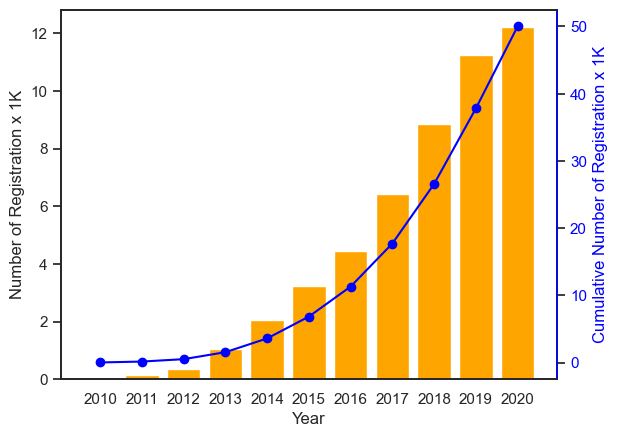

In [67]:
fig,ax=plt.subplots()
x=dt.year.value_counts().sort_index().index
y=0.001*dt.year.value_counts().sort_index()
ax.bar(x=x,height=y,color='orange')
ax.set_xticks(x)

ax.set_xlabel('Year')
ax.set_ylabel('Number of Registration x 1K')

ax2=ax.twinx()
ax2.plot(x,y.cumsum(),'-o',color='blue')
ax2.spines["right"].set_color("blue") 
ax2.set_ylabel('Cumulative Number of Registration x 1K',color='blue')

ax2.set_yticks(np.arange(0,51,10))
ax2.set_yticklabels(labels=np.arange(0,51,10),color="blue")

plt.show()

## Gradual increase in the number of EVs from 2010 to 2015
## Number of EVs registered increased at higher rate after 2015

# Let's see which 5 EVs have the largest market share

In [68]:
dt["Vehicle Name"].value_counts()

Chevrolet Volt          6822
Tesla Model 3           6124
Tesla Model S           5906
Nissan Leaf             4429
Toyota Prius Plug-in    3738
                        ... 
Porsche 918 Spyder         5
Cadillac CT6               5
Volvo V60 Plug In          3
Mclaren P1                 3
Bentley Bentayga           1
Name: Vehicle Name, Length: 77, dtype: int64

**There are total 77 EVs in our data**

*We will make a new column to find the make of the car*

*Note: The first word in the column: 'Vehicle name' is the make of the car, and rest of the words make model*

*let's make two new columns: Make and Model*

In [69]:
dt["Make"]=dt['Vehicle Name'].apply(lambda s:s.split()[0])
dt["Model"]=dt['Vehicle Name'].apply(lambda s:''.join(s.split()[1:]))
dt.head()

,year,Vehicle Name,Make,Model
0,2016,Tesla Model S,Tesla,ModelS
1,2014,Ford Fusion Energi,Ford,FusionEnergi
2,2017,Toyota Prius Prime,Toyota,PriusPrime
3,2019,Tesla Model 3,Tesla,Model3
4,2020,Chevrolet Volt,Chevrolet,Volt


In [70]:
print(dt.Make.value_counts().shape)
dt['Make'].value_counts()


(29,)


Tesla         14593
Chevrolet      9138
Toyota         6241
Ford           4807
Nissan         4429
BMW            3102
Fiat           1708
Honda          1124
Volkswagen      951
Mercedes        622
Audi            588
Kia             573
Hyundai         461
Chrysler        355
Smart           302
Volvo           283
Porsche         246
Mitsubishi      155
Cadillac         68
Subaru           66
Fisker           54
Jaguar           49
Mini             38
Land             19
Scion            12
Karma             6
Lincoln           6
Mclaren           3
Bentley           1
Name: Make, dtype: int64

# There are 31 different EV companies in our data
# Let's calculate the market share % of top 3 company over the years

In [71]:
# dt.groupby('year').apply(lambda x : x.sort_values(by = 'value', ascending = False).head(2).reset_index(drop = True))
df_year_make=pd.crosstab(dt.year,dt.Make)

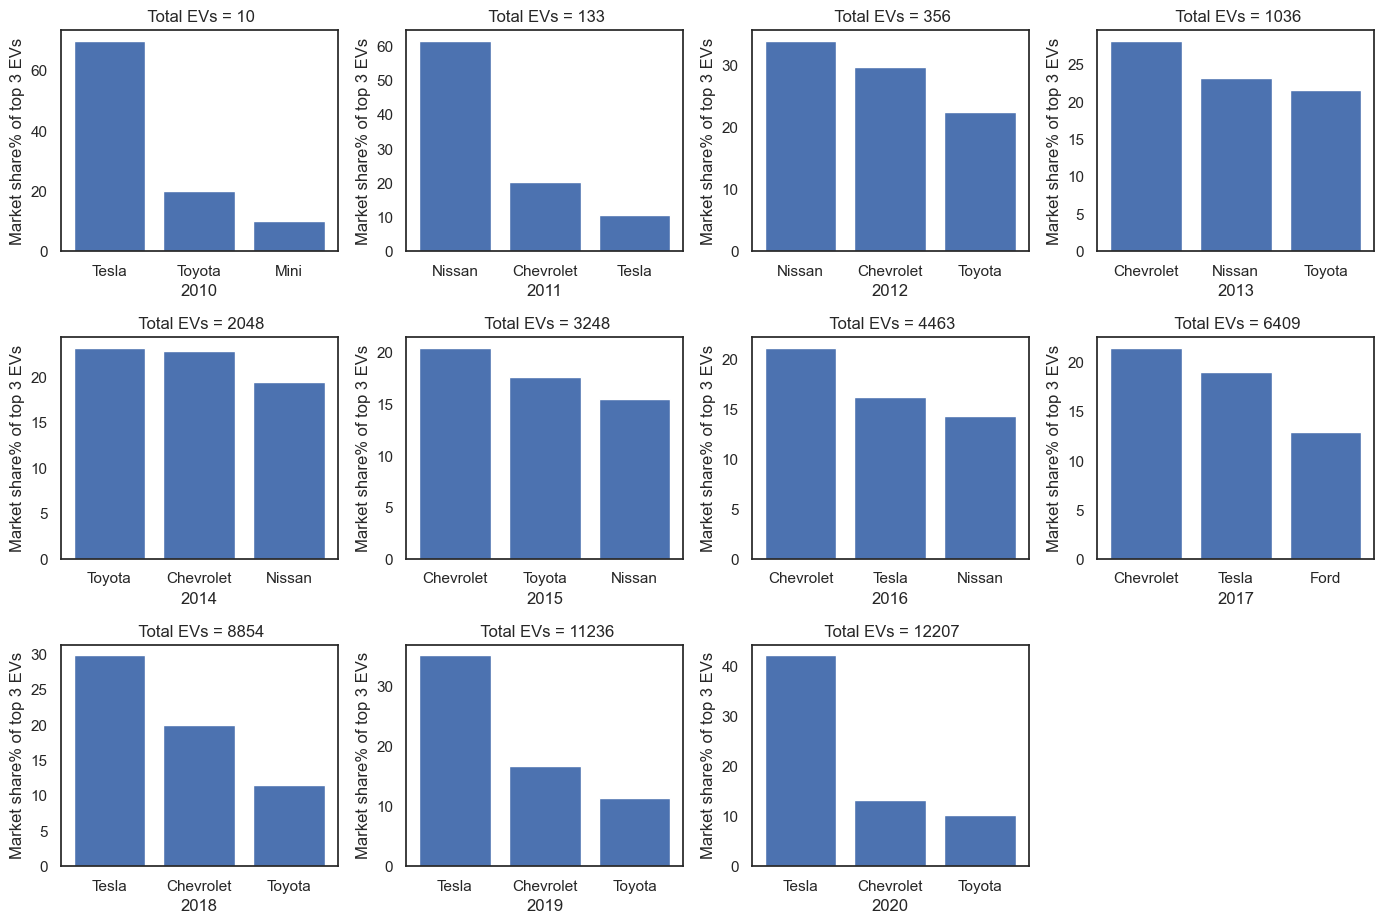

In [72]:
nr_rows = 4
nr_cols = 4
sns.set(style='white')
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        
        if i < len(df_year_make):
            year=df_year_make.index[i]
            df=100*df_year_make.iloc[i].sort_values(ascending=False)[:3]/df_year_make.iloc[i].sum()
            axs[r][c].bar(x=df.index.to_list(),height=df.values)
            axs[r][c].set_xlabel(year)
            axs[r][c].set_ylabel(f'Market share% of top 3 EVs')
            axs[r][c].set_title(f' Total EVs = {df_year_make.iloc[i].sum()}')
        else:
            fig.delaxes(axs[r][c])
            
plt.tight_layout()    
# # plt.savefig("./Figures/Ered_desc2.png",dpi=300)
plt.show()  

# Bar chart racing

# Tesla EVs registration over the period of 2010 to 2020

<BarContainer object of 11 artists>

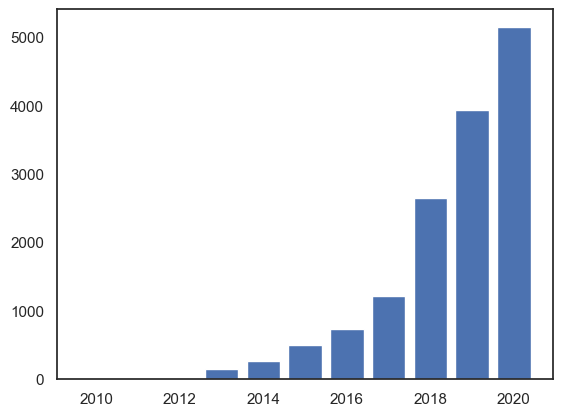

In [73]:
plt.bar(df_year_make['Tesla'].index.to_list(),height=df_year_make['Tesla'].values)

In [74]:
import plotly.express as px

In [75]:
dt["EVs"]=1  # plotly will make group of make and count the number of EVs sold each year

plotly fig too large to upload on github

In [78]:
fig_bar = px.histogram(dt.sort_values(by='year'), x="Make", y="EVs", color="Make",
                 animation_frame="year", animation_group="Make",
                 range_y=[0,5200],
                 color_discrete_sequence=px.colors.qualitative.T10)
fig_bar.update_yaxes(showgrid=False),
fig_bar.update_xaxes(categoryorder='total descending')

# fig_bar.update_traces(textposition='inside')
fig_bar.update_layout(margin=dict(t=70, b=0, l=70, r=40),
                        hovermode="x unified",
                        xaxis_tickangle=360,
                        xaxis_title=' ', yaxis_title=" ",
                        plot_bgcolor='#2d3035', paper_bgcolor='#2d3035',
                        title_font=dict(size=25, color='#a5a7ab', family="Lato, sans-serif"),
                        font=dict(color='#8a8d93'),
                        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
                          )
fig_bar.show()

# TODO
## combine all states and make a statewise heatmap 

In [80]:
url = 'https://gist.githubusercontent.com/johnburnmurdoch/4199dbe55095c3e13de8d5b2e5e5307a/raw/fa018b25c24b7b5f47fd0568937ff6c04e384786/city_populations'
df2 = pd.read_csv(url, usecols=['name', 'group', 'year', 'value'])
df2.head(3)

,name,group,year,value
0,Agra,India,1575,200.0
1,Agra,India,1576,212.0
2,Agra,India,1577,224.0


In [81]:
dt

,year,Vehicle Name,Make,Model,EVs
0,2016,Tesla Model S,Tesla,ModelS,1
1,2014,Ford Fusion Energi,Ford,FusionEnergi,1
2,2017,Toyota Prius Prime,Toyota,PriusPrime,1
3,2019,Tesla Model 3,Tesla,Model3,1
4,2020,Chevrolet Volt,Chevrolet,Volt,1
...,...,...,...,...,...
49995,2017,Fiat 500e,Fiat,500e,1
49996,2018,Chevrolet Volt,Chevrolet,Volt,1
49997,2018,BMW i3,BMW,i3,1
49998,2017,Nissan Leaf,Nissan,Leaf,1


In [86]:
df=dt

In [99]:
df

,year,Vehicle Name,Make,Model,EVs
0,2016,Tesla Model S,Tesla,ModelS,1
1,2014,Ford Fusion Energi,Ford,FusionEnergi,1
2,2017,Toyota Prius Prime,Toyota,PriusPrime,1
3,2019,Tesla Model 3,Tesla,Model3,1
4,2020,Chevrolet Volt,Chevrolet,Volt,1
...,...,...,...,...,...
49995,2017,Fiat 500e,Fiat,500e,1
49996,2018,Chevrolet Volt,Chevrolet,Volt,1
49997,2018,BMW i3,BMW,i3,1
49998,2017,Nissan Leaf,Nissan,Leaf,1


In [100]:
df2

,name,group,year,value
0,Agra,India,1575,200.0
1,Agra,India,1576,212.0
2,Agra,India,1577,224.0
3,Agra,India,1578,236.0
4,Agra,India,1579,248.0
...,...,...,...,...
6247,Vijayanagar,India,1561,480.0
6248,Vijayanagar,India,1562,480.0
6249,Vijayanagar,India,1563,480.0
6250,Vijayanagar,India,1564,480.0


In [101]:
df_year_make

Make,Audi,BMW,Bentley,Cadillac,Chevrolet,Chrysler,Fiat,Fisker,Ford,Honda,...,Mitsubishi,Nissan,Porsche,Scion,Smart,Subaru,Tesla,Toyota,Volkswagen,Volvo
year,,,,,,,,,,,,,,,,,,,,,
2010,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,7,2,0,0
2011,0,0,0,0,27,0,0,0,1,0,...,0,82,0,0,1,0,14,6,0,0
2012,0,8,0,0,106,0,0,5,8,0,...,3,121,0,0,7,0,18,80,0,0
2013,0,9,0,0,292,0,7,11,83,8,...,6,240,0,4,12,0,139,224,0,0
2014,0,26,0,4,469,0,108,10,237,23,...,5,398,1,2,33,0,255,475,0,0
2015,0,119,0,5,664,0,248,1,456,24,...,3,503,12,1,48,0,489,573,46,0
2016,39,285,0,9,943,0,324,3,614,31,...,8,640,20,1,46,0,726,567,103,9
2017,83,469,0,11,1377,21,361,9,829,49,...,7,697,46,1,42,0,1218,769,205,23
2018,117,632,0,15,1772,80,275,4,861,190,...,29,574,45,3,34,0,2641,1019,182,44


In [105]:
len(df_year_make['Tesla'].index),len(df_year_make['Tesla'].values)

(11, 11)

In [146]:
df_dic={}

for idx,make in enumerate(df_year_make.columns):
    
    year=df_year_make[make].index.to_list()
    com=[make]*len(year)
    count=list(df_year_make[make].values)
    df_dic["year"]=year
    df_dic["Make"]=com
    df_dic["Sold"]=count
    co=co+len(year)
    if idx==0:
        df_new=pd.DataFrame(df_dic)
    else:
        df_new=pd.concat([df_new,pd.DataFrame(df_dic)])

In [147]:
df_new

,year,Make,Sold
0,2010,Audi,0
1,2011,Audi,0
2,2012,Audi,0
3,2013,Audi,0
4,2014,Audi,0
...,...,...,...
6,2016,Volvo,9
7,2017,Volvo,23
8,2018,Volvo,44
9,2019,Volvo,90


In [148]:
from raceplotly.plots import barplot

In [152]:
my_raceplot = barplot(df_new,  item_column='Make', value_column='Sold', time_column='year')
my_raceplot.plot(item_label = 'Make', value_label = 'EVs Registered', frame_duration = 600)